Find some new papers discussion DL applications in regression/analytic continuation. (How to write the paper, what precision could be achieved etc.?)

Maybe we need to try to predict values that are completely outside the range of the current physical parameters and compare with the correct entropy. Make a plot and see if we can extract any information regarding the analytic expressions.

Is it possible to smooth out the relative error?

Do some other examples, mutual information, XXZ spin chain. (only for two intervals in decompactification limit)

For XXZ spin-chain, train the data outside the range in the paper. Then predict the values for the range in the paper.

The final case should be a unsupervised or semi-supervised learning problem, are there suitable regression algorithms?

Notes:

On general workflow, check the DL Entropy (Single Interval).ipynb file. Also, the file includes training without using KerasTuner, Reduce model size with regularization, Reduce data sets (with K-fold validation).

On testing predictions outside the training range (and split data with interval), check DL Mutual Information (Decompactification Limit and XXZ Spin-Chain).ipynb.

Check each file for the parameters range and data distribution.

### Singel Interval

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 13s]
val_loss: 0.00010043671181847458

Best val_loss So Far: 0.00010043671181847458
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 1ms/step - loss: 0.4975 - mae: 0.4878
Epoch 2/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0139 - mae: 0.0931
Epoch 3/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0119 - mae: 0.0860
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0097 - mae: 0.0775
Epoch 5/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0074 - mae: 0.0678
Epoch 6/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0053 - mae: 0.0573
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0034 - mae: 0.0463
Epoch 8/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0356
Epoch 9/60
282/282 [==============================] - 0s 1ms

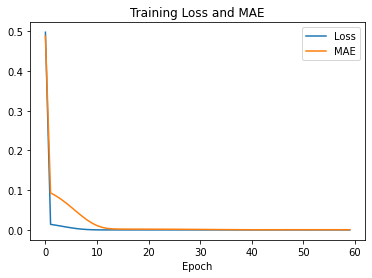

     Correct Entropy  Model Predictions
0            1.92547           1.925510
1            1.83266           1.832837
2            1.52335           1.523059
3            1.83660           1.836770
4            1.82135           1.821525
..               ...                ...
995          1.77604           1.776207
996          1.94712           1.947099
997          1.71134           1.711443
998          1.55777           1.557551
999          1.99351           1.993305

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0            1.92547           1.925510             1.809038
1            1.83266           1.832837             1.728620
2            1.52335           1.523059             1.454180
3            1.83660           1.836770             1.732049
4            1.82135           1.821525             1.718753
..               ...                ...                  ...
995          1.77604           

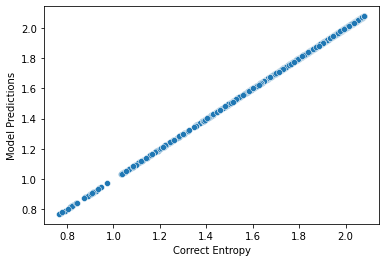

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Data_Single_Interval_1.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
# df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="singleintervaltest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

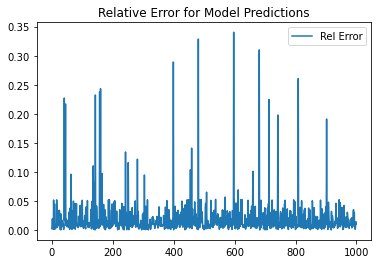

In [3]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Single Interval at Finite Temperature and Finite Length

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 08s]
val_loss: 3.997875137429219e-05

Best val_loss So Far: 3.997875137429219e-05
Total elapsed time: 00h 00m 08s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 1ms/step - loss: 0.1093 - mae: 0.1624
Epoch 2/60
282/282 [==============================] - 0s 937us/step - loss: 0.0045 - mae: 0.0235
Epoch 3/60
282/282 [==============================] - 0s 902us/step - loss: 9.5553e-04 - mae: 0.0126
Epoch 4/60
282/282 [==============================] - 0s 898us/step - loss: 3.8019e-04 - mae: 0.0074
Epoch 5/60
282/282 [==============================] - 0s 955us/step - loss: 1.8188e-04 - mae: 0.0043
Epoch 6/60
282/282 [==============================] - 0s 1ms/step - loss: 1.1513e-04 - mae: 0.0041
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 8.0354e-05 - mae: 0.0039
Epoch 8/60
282/282 [==============================] - 0s 987us/step - loss: 6.2183e-05 - mae: 0.0037
Epoch 9/60
282/282 [========

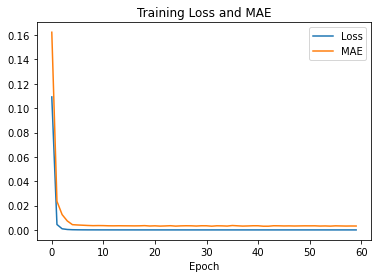

     Correct Entropy  Model Predictions
0           0.386110           0.387076
1           0.387808           0.388735
2           0.549440           0.551686
3           0.387647           0.388577
4           0.388348           0.389263
..               ...                ...
995         0.392065           0.392914
996         0.386032           0.386999
997         0.404789           0.405510
998         0.507738           0.509385
999         0.385968           0.386937

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0           0.386110           0.387076             0.379962
1           0.387808           0.388735             0.381494
2           0.549440           0.551686             0.534579
3           0.387647           0.388577             0.381349
4           0.388348           0.389263             0.381982
..               ...                ...                  ...
995         0.392065           

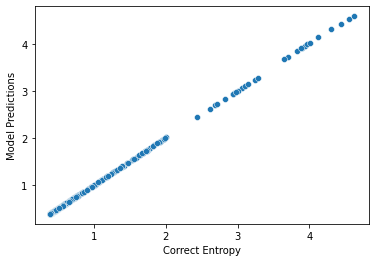

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Data_Single_Interval_allT.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
# df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="FiniteTtest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

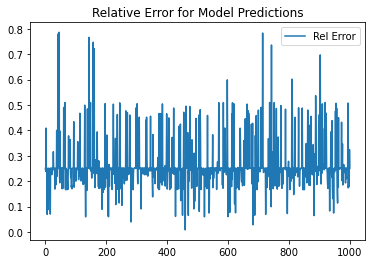

In [2]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Two Intervals at Small x Expansion (First Order in x)

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 06s]
val_loss: 4.868374344368931e-05

Best val_loss So Far: 4.868374344368931e-05
Total elapsed time: 00h 00m 06s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 1ms/step - loss: 0.3889 - mae: 0.4241
Epoch 2/60
282/282 [==============================] - 0s 926us/step - loss: 0.0026 - mae: 0.0332
Epoch 3/60
282/282 [==============================] - 0s 926us/step - loss: 2.7383e-04 - mae: 0.0115
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 5.4794e-05 - mae: 0.0063
Epoch 5/60
282/282 [==============================] - 0s 976us/step - loss: 5.0209e-05 - mae: 0.0063
Epoch 6/60
282/282 [==============================] - 0s 990us/step - loss: 4.8268e-05 - mae: 0.0063
Epoch 7/60
282/282 [==============================] - 0s 972us/step - loss: 4.7793e-05 - mae: 0.0063
Epoch 8/60
282/282 [==============================] - 0s 990us/step - loss: 4.6022e-05 - mae: 0.0062
Epoch 9/60
282/282 [======

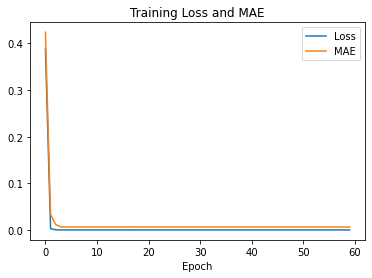

     Correct Entropy  Model Predictions
0           1.617062           1.623717
1           1.590116           1.596640
2           1.413182           1.420149
3           1.591590           1.598113
4           1.585735           1.592267
..               ...                ...
995         1.566221           1.572808
996         1.620583           1.627343
997         1.533545           1.540250
998         1.437702           1.444646
999         1.623558           1.630702

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0           1.617062           1.623717             1.506234
1           1.590116           1.596640             1.485256
2           1.413182           1.420149             1.335194
3           1.591590           1.598113             1.486444
4           1.585735           1.592267             1.481714
..               ...                ...                  ...
995         1.566221           

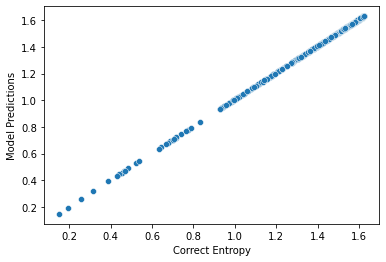

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Data_Two_Interval_Firstx.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
# df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="SmallxFirstTest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

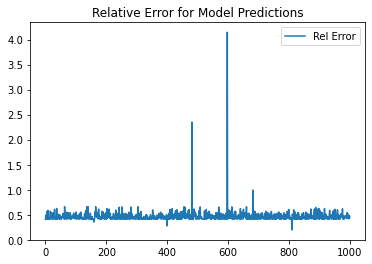

In [2]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Two Intervals at Small x Expansion (Second Order in x)

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 14s]
val_loss: 0.0006402234360507464

Best val_loss So Far: 0.0006402234360507464
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 997us/step - loss: 0.7025 - mae: 0.6229
Epoch 2/60
282/282 [==============================] - 0s 987us/step - loss: 0.0107 - mae: 0.0729
Epoch 3/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0098 - mae: 0.0697
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0087 - mae: 0.0656
Epoch 5/60
282/282 [==============================] - 0s 980us/step - loss: 0.0074 - mae: 0.0608
Epoch 6/60
282/282 [==============================] - 0s 987us/step - loss: 0.0061 - mae: 0.0551
Epoch 7/60
282/282 [==============================] - 0s 990us/step - loss: 0.0048 - mae: 0.0489
Epoch 8/60
282/282 [==============================] - 0s 976us/step - loss: 0.0036 - mae: 0.0423
Epoch 9/60
282/282 [==============================

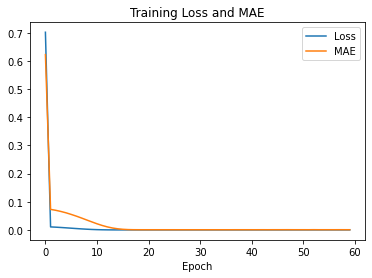

     Correct Entropy  Model Predictions
0           1.997747           1.997137
1           1.943323           1.943114
2           1.681152           1.681342
3           1.945952           1.945726
4           1.935628           1.935466
..               ...                ...
995         1.902965           1.902976
996         2.007714           2.007018
997         1.851898           1.852097
998         1.714542           1.714799
999         2.024449           2.023605

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0           1.997747           1.997137             1.871585
1           1.943323           1.943114             1.824819
2           1.681152           1.681342             1.595504
3           1.945952           1.945726             1.827084
4           1.935628           1.935466             1.818186
..               ...                ...                  ...
995         1.902965           

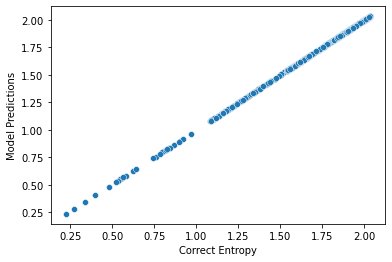

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Data_Two_Interval_Secondx.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
# df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="SmallxSecondTest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

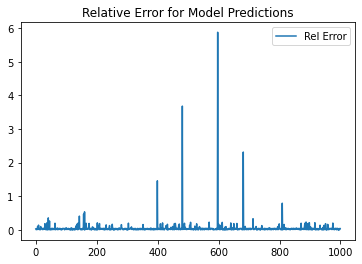

In [2]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Two Intervals at Decompactification Limit

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 06s]
val_loss: 3.427459887461737e-05

Best val_loss So Far: 3.427459887461737e-05
Total elapsed time: 00h 00m 06s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 972us/step - loss: 0.8417 - mae: 0.7035
Epoch 2/60
282/282 [==============================] - 0s 930us/step - loss: 0.0050 - mae: 0.0579
Epoch 3/60
282/282 [==============================] - 0s 937us/step - loss: 7.9510e-04 - mae: 0.0218
Epoch 4/60
282/282 [==============================] - 0s 969us/step - loss: 6.0370e-05 - mae: 0.0066
Epoch 5/60
282/282 [==============================] - 0s 955us/step - loss: 4.1775e-05 - mae: 0.0062
Epoch 6/60
282/282 [==============================] - 0s 1ms/step - loss: 4.1256e-05 - mae: 0.0062
Epoch 7/60
282/282 [==============================] - 0s 994us/step - loss: 4.1235e-05 - mae: 0.0062
Epoch 8/60
282/282 [==============================] - 0s 980us/step - loss: 4.1430e-05 - mae: 0.0062
Epoch 9/60
282/282 [====

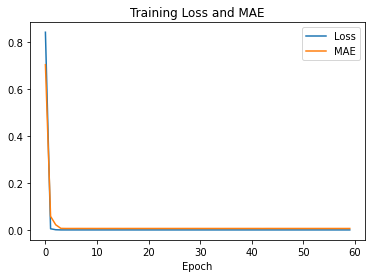

     Correct Entropy  Model Predictions
0            1.83841           1.831378
1            1.73304           1.726399
2            1.44152           1.435189
3            1.73736           1.730709
4            1.72069           1.714084
..               ...                ...
995          1.67243           1.665910
996          1.86398           1.856806
997          1.60693           1.600480
998          1.46890           1.462541
999          1.91991           1.912345

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0            1.83841           1.831378             1.711344
1            1.73304           1.726399             1.614747
2            1.44152           1.435189             1.344569
3            1.73736           1.730709             1.618719
4            1.72069           1.714084             1.603391
..               ...                ...                  ...
995          1.67243           

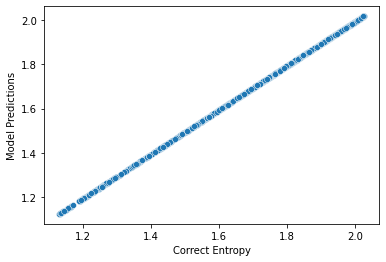

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Data_Two_Interval_decom.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
# df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="DecomTest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

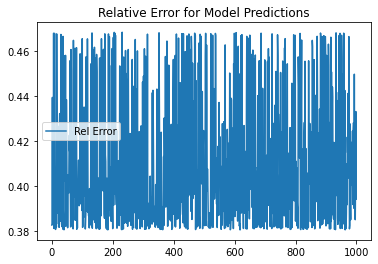

In [2]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Mutual Information at Decompactification Limit

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

Trial 1 Complete [00h 00m 12s]
val_loss: 1.2171287380624563e-05

Best val_loss So Far: 1.2171287380624563e-05
Total elapsed time: 00h 00m 12s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 990us/step - loss: 0.1799 - mae: 0.3403
Epoch 2/60
282/282 [==============================] - 0s 987us/step - loss: 0.0226 - mae: 0.1277
Epoch 3/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0153 - mae: 0.1061
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0083 - mae: 0.0779
Epoch 5/60
282/282 [==============================] - 0s 958us/step - loss: 0.0032 - mae: 0.0477
Epoch 6/60
282/282 [==============================] - 0s 976us/step - loss: 7.7691e-04 - mae: 0.0234
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 1.5014e-04 - mae: 0.0101
Epoch 8/60
282/282 [==============================] - 0s 983us/step - loss: 5.7273e-05 - mae: 0.0064
Epoch 9/60
282/282 [==================

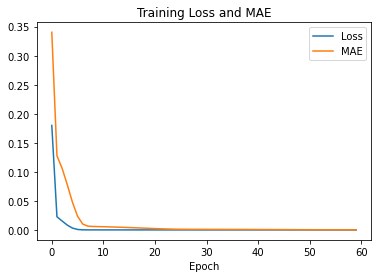

     Correct Entropy  Model Predictions
0           0.457445           0.456966
1           0.562814           0.562384
2           0.854334           0.853978
3           0.558494           0.558061
4           0.575158           0.574738
..               ...                ...
995         0.623420           0.623034
996         0.431874           0.431405
997         0.688920           0.688570
998         0.826955           0.826609
999         0.375940           0.375550

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0           0.457445           0.456966             0.454035
1           0.562814           0.562384             0.559165
2           0.854334           0.853978             0.849617
3           0.558494           0.558061             0.554856
4           0.575158           0.574738             0.571480
..               ...                ...                  ...
995         0.623420           

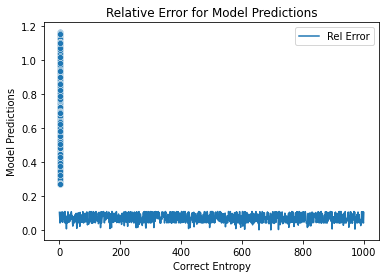

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_decom.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)


# if we want to reduce the dims of the data (keep k=10)
df2 = df1.iloc[range(0,10000),range(0,10)]
# remember to change X = df2


X = df2
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="MutualInfoDecomTest", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

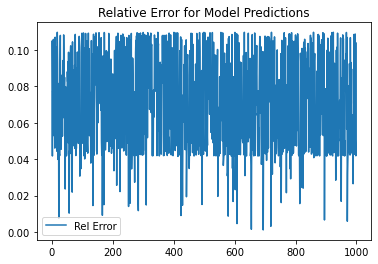

In [3]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Mutual Information of the XXZ Spin-Chain Model

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

In [4]:
df

,Correct Entropy,Approx Entropy,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,0.310335,0.311781,0.310014,0.037221,-0.000650,-0.005921,-0.005479,-0.004283,-0.003255,-0.002493,...,-0.000061,-0.000058,-0.000055,-0.000052,-0.000049,-0.000047,-0.000044,-0.000042,-0.000040,-0.000038
1,0.310432,0.311878,0.310070,0.037243,-0.000641,-0.005917,-0.005477,-0.004282,-0.003254,-0.002492,...,-0.000061,-0.000058,-0.000055,-0.000052,-0.000049,-0.000047,-0.000044,-0.000042,-0.000040,-0.000038
2,0.310530,0.311976,0.310125,0.037266,-0.000632,-0.005913,-0.005475,-0.004281,-0.003253,-0.002492,...,-0.000061,-0.000058,-0.000055,-0.000052,-0.000049,-0.000047,-0.000044,-0.000042,-0.000040,-0.000038
3,0.310628,0.312074,0.310181,0.037288,-0.000622,-0.005908,-0.005473,-0.004280,-0.003253,-0.002491,...,-0.000061,-0.000058,-0.000055,-0.000052,-0.000049,-0.000047,-0.000044,-0.000042,-0.000040,-0.000038
4,0.310726,0.312172,0.310236,0.037310,-0.000613,-0.005904,-0.005471,-0.004278,-0.003252,-0.002491,...,-0.000061,-0.000058,-0.000055,-0.000052,-0.000049,-0.000047,-0.000044,-0.000042,-0.000040,-0.000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.535920,3.580159,0.967851,0.468897,0.303223,0.220831,0.171726,0.139244,0.116243,0.099156,...,0.011692,0.011309,0.010947,0.010604,0.010279,0.009970,0.009677,0.009399,0.009133,0.008881
9996,4.671500,3.640970,0.970881,0.471760,0.305930,0.223394,0.174154,0.141546,0.118428,0.101232,...,0.012289,0.011890,0.011513,0.011156,0.010817,0.010495,0.010190,0.009899,0.009622,0.009359
9997,4.846790,3.715168,0.974382,0.475084,0.309088,0.226397,0.177011,0.144266,0.121021,0.103704,...,0.013053,0.012635,0.012239,0.011864,0.011509,0.011171,0.010850,0.010544,0.010253,0.009975
9998,5.094730,3.811793,0.978630,0.479140,0.312964,0.230103,0.180557,0.147661,0.124272,0.106820,...,0.014112,0.013669,0.013249,0.012851,0.012472,0.012113,0.011771,0.011445,0.011135,0.010838


Trial 1 Complete [00h 00m 13s]
val_loss: 0.0007725915929768234

Best val_loss So Far: 0.0007725915929768234
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/60
282/282 [==============================] - 1s 1ms/step - loss: 0.1871 - mae: 0.2713
Epoch 2/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0046 - mae: 0.0354
Epoch 3/60
282/282 [==============================] - 0s 1ms/step - loss: 5.0158e-04 - mae: 0.0086
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 4.3967e-04 - mae: 0.0083
Epoch 5/60
282/282 [==============================] - 0s 1ms/step - loss: 4.0308e-04 - mae: 0.0088
Epoch 6/60
282/282 [==============================] - 0s 1ms/step - loss: 3.7540e-04 - mae: 0.0088
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 3.5259e-04 - mae: 0.0092
Epoch 8/60
282/282 [==============================] - 0s 1ms/step - loss: 3.3619e-04 - mae: 0.0092
Epoch 9/60
282/282 [==================

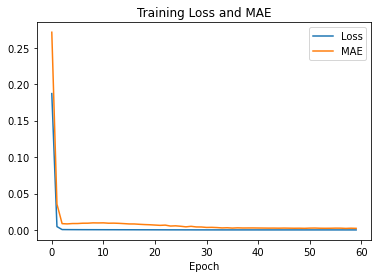

     Correct Entropy  Model Predictions
0           0.871919           0.874441
1           0.706852           0.707561
2           0.461749           0.465878
3           0.712208           0.713006
4           0.692011           0.692460
..               ...                ...
995         0.639614           0.640654
996         0.928706           0.931460
997         0.579403           0.582038
998         0.478746           0.482816
999         1.101600           1.104123

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)
     Correct Entropy  Model Predictions  Approximate Entropy
0           0.871919           0.874441             0.863325
1           0.706852           0.707561             0.703680
2           0.461749           0.465878             0.462594
3           0.712208           0.713006             0.708894
4           0.692011           0.692460             0.689217
..               ...                ...                  ...
995         0.639614           

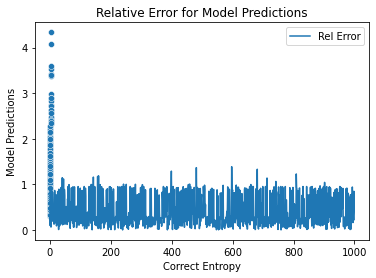

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_XXZ.csv', encoding='utf-8', encoding_errors='ignore')
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)

X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 

tuner = kt.BayesianOptimization(build_model, 
                                objective="val_loss", 
                                max_trials=1, 
                                executions_per_trial=2, 
                                directory="MutualInfoXXZ", 
                                overwrite=True, 
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)



top_n = 4 
best_hps = tuner.get_best_hyperparameters(top_n) 

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

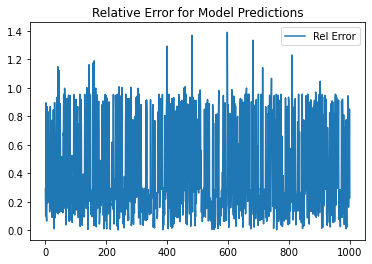

In [3]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()